In [1]:
!pip install procgen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.7/267.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: imageio-ffmpeg
    Found existing installation: imageio-ffmpeg 0.5.1
    Uninstalling imageio-ffmpeg-0.5.1:
      Successfully uninstalled imageio-ffmpeg-0.5.1


In [2]:
#Importing necessaries libraries
import gym
import random
import json
import tensorflow_probability as tfp
import tensorflow.keras.losses as kls
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import json

In [3]:
#Setting random seed to make the notebook reproducibile
np.random.seed(33)
random.seed(33)
tf.random.set_seed(33)
seed = 33

# Neural Network architecture

Two different networks are used for actor and critic but a base network is used to share first layers since the image pattern part can be shared both for actor and critic.

So just classification head is different between actor and critic netwrok

In [4]:
class basemodel(tf.keras.Model):
    def __init__(self):
        super(basemodel, self).__init__()
        self.rescale = tf.keras.layers.Rescaling(1./255)
        self.conv1 = tf.keras.layers.Conv2D(16, (7, 7), activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(16, (5, 5), activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
        self.flatten = tf.keras.layers.Flatten()

    def call(self, state):
        x = self.rescale(state)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        return x

class actor(tf.keras.Model):
    def __init__(self, base, action_space=16):
        super(actor, self).__init__()
        self.base = base
        self.dense1 = tf.keras.layers.Dense(64, activation='relu')
        self.output_layer = tf.keras.layers.Dense(action_space, activation='softmax')

    def call(self, state):
        x = self.base(state)
        x = self.dense1(x)
        return self.output_layer(x)

class critic(tf.keras.Model):
    def __init__(self, base):
        super(critic, self).__init__()
        self.base = base
        self.dense1 = tf.keras.layers.Dense(64, activation='relu')
        self.output_layer = tf.keras.layers.Dense(1, activation='linear')

    def call(self, state):
        x = self.base(state)
        x = self.dense1(x)
        return self.output_layer(x)

# PPO Agent

In this section the PPO Agent classis implemented.

In [5]:
class PPOagent():
    def __init__(self, gamma, actor_learning_rate, critc_learning_rate, clip_pram, entropy_param, critic_loss_param):
        self.basemodel = basemodel()
        self.actor = actor(self.basemodel)
        self.critic = critic(self.basemodel)
        self.gamma = gamma
        self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate=actor_learning_rate)
        self.critic_optimizer = tf.keras.optimizers.Adam(learning_rate=critc_learning_rate)
        self.clip_pram = clip_pram
        self.entropy_param  = entropy_param
        self.critic_loss_param  = critic_loss_param

    def action(self,state):
        """
        Selects an action based on the current state using the actor network.

        Parameters:
          state (array-like): The current state of the environment.

        Returns:
          int: The selected action.
        """

        prob = self.actor(state)
        prob = prob.numpy()
        dist = tfp.distributions.Categorical(probs=prob, dtype=tf.float32)
        action = dist.sample()
        return int(action.numpy()[0])

    def critic_loss(self, discounted_rewards, values):
        """
        Computes and returns the critic loss using mean squared error.

        Parameters:
          discounted_rewards (array-like): The discounted rewards.
          values (array-like): The values predicted by the critic.

        Returns:
          tf.Tensor: The computed critic loss.
        """

        return kls.mean_squared_error(discounted_rewards, values)

    def actor_loss(self, probs, actions, advantages, old_probs, critic_loss):
        """
        Computes and returns the actor loss using the PPO objective.

        Parameters:
          probs (array-like): The probabilities of actions taken.
          actions (array-like): The actions taken.
          advantages (array-like): The advantages calculated from rewards.
          old_probs (array-like): The probabilities of actions from the previous policy.
          critic_loss (tf.Tensor): The loss from the critic network.

        Returns:
          tf.Tensor: The computed actor loss.
        """

        clipped_loss_terms = []
        for prob, adv, old_prob, action  in zip(probs, advantages, old_probs, actions):
          ratio = tf.math.divide(prob[action],old_prob[action])
          clipped_ratio = tf.clip_by_value(ratio, 1.0 - self.clip_pram, 1.0 + self.clip_pram)
          clipped_term = tf.math.minimum(tf.math.multiply(ratio,adv), tf.math.multiply(clipped_ratio,adv))
          clipped_loss_terms.append(clipped_term)

        clipped_loss = tf.reduce_mean(clipped_loss_terms)
        entropy = tf.reduce_mean(tf.math.negative(tf.math.multiply(probs,tf.math.log(probs))))

        loss = tf.math.negative(clipped_loss - self.critic_loss_param * critic_loss + self.entropy_param * entropy)
        return loss

    def compute_discounted_rewards(self, rewards, dones, values, gamma, lmbda = 0.95):
        """
        Computes and returns the discounted rewards.

        Parameters:
          rewards (array-like): The rewards received.
          done (array-like): Boolean array indicating if the episode is done.
          values (array-like): The values predicted by the critic.
          gamma (float): Discount factor for future rewards.
          lmbda (float, optional): Lambda parameter for Generalized Advantage Estimation (GAE). Default is 0.95.

        Returns:
          np.array: The discounted rewards.
        """
        G = 0
        discounted_rewards = []
        for i in reversed(range(len(rewards))):
          td_error = rewards[i] + gamma * values[i + 1] * done[i] - values[i]
          G = td_error + gamma * lmbda * dones[i] * G
          discounted_rewards.append(G + values[i])
        discounted_rewards.reverse()
        return np.array(discounted_rewards, dtype=np.float32)

    def compute_advantages(self, values, discounted_rewards):
        """
        Computes and returns the advantages.

        Parameters:
          discounted_rewards (array-like): The discounted rewards.

        Returns:
          np.array: The computed advantages.
        """
        advantages = discounted_rewards - values[:-1]
        advantages = (advantages - np.mean(advantages)) / (np.std(advantages) + 1e-10)
        return advantages

    def normalize_rewards(self, rewards, min_reward=0, max_reward=10):
        """
        Normalizes the rewards to a specified range.

        Parameters:
          rewards (array-like): The rewards to normalize.
          min_reward (float, optional): The minimum reward for normalization. Default is 0.
          max_reward (float, optional): The maximum reward for normalization. Default is 10.

        Returns:
          list: The normalized rewards.
        """

        return [(x - min_reward) / (max_reward - min_reward) for x in rewards]

    def train(self, states, actions, rewards, dones, values, probs, epochs):
        """
        Manages the entire training process for both the actor and critic networks.

        Parameters:
          states (array-like): The states experienced.
          actions (array-like): The actions taken.
          rewards (array-like): The rewards received.
          dones (array-like): Boolean array indicating if the episode is done.
          values (array-like): The values predicted by the critic.
          probs (array-like): The probabilities of actions taken.
          epochs (int): The number of training epochs.
        """

        #Normalize rewards
        rewards = self.normalize_rewards(rewards)

        #Compute discounted rewards and advantages
        discounted_rewards = self.compute_discounted_rewards(rewards, dones, values, self.gamma)
        advantages = self.compute_advantages(discounted_rewards)

        #Numpy array preprocessing
        states = np.array(states, dtype=np.float32)
        actions = np.array(actions, dtype=np.int32)
        discounted_rewards = tf.reshape(discounted_rewards, (len(discounted_rewards),))
        advantages = tf.reshape(advantages, (len(advantages),))

        #Training loop
        for i in range(epochs):
          with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
              new_probs = self.actor(states, training=True)
              new_values =  self.critic(states,training=True)
              new_values = tf.reshape(new_values, (len(new_values),))
              critic_loss = self.critic_loss(discounted_rewards, new_values)
              actor_loss = self.actor_loss(new_probs, actions, advantages, probs, critic_loss)

          actor_grads = tape1.gradient(actor_loss, self.actor.trainable_variables)
          critic_grads = tape2.gradient(critic_loss, self.critic.trainable_variables)
          self.actor_optimizer.apply_gradients(zip(actor_grads, self.actor.trainable_variables))
          self.critic_optimizer.apply_gradients(zip(critic_grads, self.critic.trainable_variables))

# CoinRun

In [10]:
env = gym.make("procgen:procgen-coinrun-v0", distribution_mode="easy", use_backgrounds=False, num_levels=200, start_level=seed, rand_seed=seed)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [6]:
#hyperparameters
gamma = 0.99
actor_learning_rate = 1e-4
critc_learning_rate = 1e-4
clip_param = 0.2
entropy_param = 0.00001
critic_loss_param = 0.5
batch_size = 512
epochs = 3

In [7]:
agent_coinrun = PPOagent(gamma, actor_learning_rate, critc_learning_rate, clip_param, entropy_param, critic_loss_param)
action_space = 16
time_steps = 0
max_time_steps = 200000

## Training PPO Agent

In [11]:
scores = []
score = 0
state = env.reset()

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


In [14]:
#Load weights
agent_coinrun.actor([state])
agent_coinrun.critic([state])
agent_coinrun.actor.load_weights('coinrun_actor_200192.h5')
agent_coinrun.critic.load_weights('coinrun_critic_200192.h5')
#with open('coinrun scores.json', 'r') as f:
#    scores = json.load(f)
#time_steps = 100352

In [ ]:
while time_steps < max_time_steps:
  done = False

  #Initializing lists
  actions = []
  states = []
  rewards = []
  dones = []
  probs = []
  values = []

  #Batch rollout
  for _ in range(batch_size):
    action = agent_coinrun.action([state]) #Actor performs action from state
    value = agent_coinrun.critic([state]).numpy() #Critic evaluate state
    next_state, reward, done, _ = env.step(action) #Simulate new state, reward and done

    if reward != 0:
      print(reward)

    #Populate lists
    actions.append(action)
    states.append(state)
    rewards.append(reward)
    dones.append(1-done)
    probs.append(agent_coinrun.actor([state])[0])
    values.append(value[0][0])

    state = next_state
    time_steps += 1
    score += reward

    if done:
      scores.append(score)
      score = 0

  value = agent_coinrun.critic([state]).numpy()
  values.append(value[0][0])

  #Train agent
  agent_coinrun.train(states, actions, rewards, dones, values, probs, epochs)

  print("timesteps:",time_steps)

env.close()

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


timesteps: 100864
10.0
10.0
10.0
10.0
10.0
timesteps: 101376
10.0
10.0
10.0
10.0
10.0
timesteps: 101888
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
timesteps: 102400
10.0
10.0
10.0
10.0
10.0
timesteps: 102912
10.0
10.0
10.0
10.0
timesteps: 103424
10.0
10.0
10.0
10.0
10.0
10.0
10.0
timesteps: 103936
10.0
10.0
10.0
10.0
10.0
10.0
timesteps: 104448
10.0
10.0
10.0
10.0
10.0
10.0
10.0
timesteps: 104960
10.0
10.0
10.0
10.0
timesteps: 105472
10.0
10.0
10.0
10.0
timesteps: 105984
10.0
10.0
10.0
10.0
10.0
timesteps: 106496
10.0
10.0
10.0
10.0
10.0
10.0
timesteps: 107008
10.0
10.0
10.0
10.0
10.0
timesteps: 107520
10.0
10.0
10.0
timesteps: 108032
10.0
10.0
10.0
10.0
10.0
10.0
timesteps: 108544
10.0
10.0
10.0
10.0
10.0
10.0
timesteps: 109056
10.0
10.0
10.0
10.0
10.0
timesteps: 109568
10.0
10.0
10.0
10.0
10.0
10.0
timesteps: 110080
10.0
10.0
10.0
10.0
10.0
timesteps: 110592
10.0
10.0
10.0
10.0
10.0
timesteps: 111104
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
timesteps: 111616
10.0
10.0
10.0
10.0
10.0

In [ ]:
#Save weights
agent_coinrun.actor.save_weights('coinrun_actor_{}.h5'.format(time_steps))
agent_coinrun.critic.save_weights('coinrun_critic_{}.h5'.format(time_steps))
with open('scores.json', 'w') as f:
    json.dump(scores, f)

In [15]:
def mean_score(data, window_size):
  num_slices = len(scores) // window_size
  averages = []
  for i in range(0, len(scores), window_size):
      slice_data = scores[i:i + window_size]
      slice_avg = np.mean(slice_data)
      averages.append(slice_avg)
  return averages

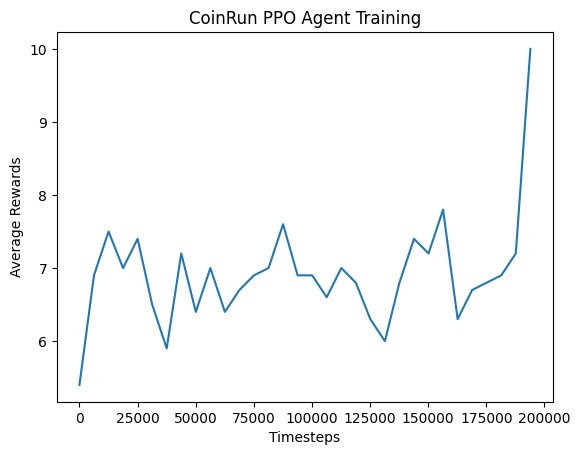

In [ ]:
#Plotting training score moving average to see training trends
mean_scores = mean_score(scores, 100)
plt.plot(range(0,time_steps,int(time_steps/len(mean_scores))),mean_scores)
plt.title('CoinRun PPO Agent Training')
plt.xlabel('Timesteps')
plt.ylabel('Average Rewards')
plt.show()

## Testing PPO Agent

In [16]:
#Setting same enviroment with infinite levels
env = gym.make("procgen:procgen-coinrun-v0", distribution_mode="easy", use_backgrounds=False, start_level=seed, rand_seed=seed)

In [17]:
test_episodes = 100

In [18]:
#Evaluating random agent
random_agent_rewards = []

for episode in range(test_episodes):
    env.reset()
    total_reward = 0

    while True:
        state, reward, done, _ = env.step(env.action_space.sample())
        total_reward += reward

        if done:
            break

    random_agent_rewards.append(total_reward)

env.close()

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


In [19]:
#Evaluating PPO agent
coinrun_ppoagent_rewards = []

for episode in range(test_episodes):
    env.reset()
    total_reward = 0

    while True:
        action = agent_coinrun.action([state])
        state, reward, done, _ = env.step(action)
        total_reward += reward

        if done:
            break

    coinrun_ppoagent_rewards.append(total_reward)

env.close()

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


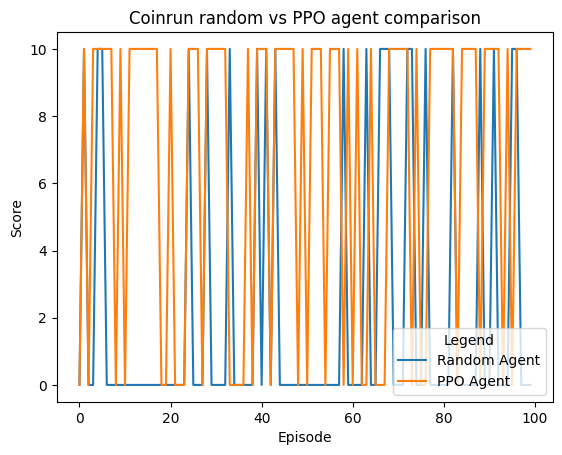

In [22]:
#Plotting a comaprison between random agent and PPO agent
plt.plot(random_agent_rewards, label='Random Agent')
plt.plot(coinrun_ppoagent_rewards, label='PPO Agent')
plt.title('Coinrun random vs PPO agent comparison')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.legend(title='Legend', loc='lower right', fontsize='medium')
plt.show()

In [21]:
print(f"CoinRun Random agent mean score over {test_episodes} episodes: {np.mean(random_agent_rewards)}")
print(f"CoinRun PPO agent mean score over {test_episodes} episodes: {np.mean(coinrun_ppoagent_rewards)}")

CoinRun Random agent mean score over 100 episodes: 2.2
CoinRun PPO agent mean score over 100 episodes: 6.7


# Fruitbot

In [ ]:
env = gym.make("procgen:procgen-fruitbot-v0", distribution_mode="easy", use_backgrounds=False, num_levels=200, start_level=seed, rand_seed=seed)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
agent_fruitbot = PPOagent(gamma, actor_learning_rate, critc_learning_rate, clip_param, entropy_param, critic_loss_param)
action_space = 16
time_steps = 0
max_time_steps = 200000

## Training PPO Agent

In [ ]:
scores = []
score = 0
state = env.reset()

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


In [ ]:
#Load weights
#agent_fruitbot.actor([state])
#agent_fruitbot.critic([state])
#agent_fruitbot.actor.load_weights('fruitbot_actor_150074.h5')
#agent_fruitbot.critic.load_weights('fruitbot_critic_150074.h5')
#with open('fruitbot_scores (3).json', 'r') as f:
#    scores = json.load(f)
#time_steps = 150074

In [ ]:
while time_steps < max_time_steps:
  done = False

  #Initializing lists
  actions = []
  states = []
  rewards = []
  dones = []
  probs = []
  values = []

  #Batch rollout
  for _ in range(batch_size):
    action = agent_fruitbot.action([state]) #Actor performs action from state
    value = agent_fruitbot.critic([state]).numpy() #Critic evaluate state
    next_state, reward, done, _ = env.step(action) #Simulate new state, reward and done

    if reward != 0:
      print(reward)

    #Populate lists
    actions.append(action)
    states.append(state)
    rewards.append(reward)
    dones.append(1-done)
    probs.append(agent_fruitbot.actor([state])[0])
    values.append(value[0][0])

    state = next_state
    time_steps += 1
    score += reward

    if done:
      scores.append(score)
      score = 0

  value = agent_fruitbot.critic([state]).numpy()
  values.append(value[0][0])

  #Train agent
  agent_fruitbot.train(states, actions, rewards, dones, values, probs, epochs)

  print("timesteps:",time_steps)

env.close()

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


-4.0
1.0
-4.0
-4.0
1.0
-4.0
-4.0
-4.0
1.0


timesteps: 150586
1.0
-4.0
1.0
1.0
-4.0
1.0
1.0
timesteps: 151098
1.0
1.0
1.0
-4.0
1.0
1.0
1.0
1.0
1.0
1.0
timesteps: 151610
1.0
1.0
1.0
1.0
1.0
1.0
1.0
-4.0
1.0
timesteps: 152122
-4.0
1.0
1.0
1.0
-4.0
1.0
1.0
-4.0
-4.0
-4.0
1.0
1.0
-4.0
-4.0
timesteps: 152634
1.0
-4.0
1.0
-4.0
timesteps: 153146
1.0
-4.0
1.0
-4.0
timesteps: 153658
1.0
-4.0
-4.0
1.0
-4.0
-4.0
-4.0
1.0
-4.0
timesteps: 154170
-4.0
1.0
1.0
1.0
1.0
timesteps: 154682
1.0
1.0
1.0
1.0
timesteps: 155194
1.0
1.0
-4.0
1.0
-4.0
1.0
-4.0
1.0
1.0
-4.0
timesteps: 155706
1.0
1.0
1.0
1.0
-4.0
1.0
-4.0
-4.0
1.0
timesteps: 156218
1.0
1.0
-4.0
timesteps: 156730
1.0
1.0
1.0
1.0
1.0
1.0
-4.0
timesteps: 157242
1.0
-4.0
1.0
1.0
1.0
-4.0
1.0
timesteps: 157754
1.0
1.0
1.0
-4.0
-4.0
-4.0
1.0
-4.0
-4.0
1.0
1.0
1.0
-4.0
timesteps: 158266
-4.0
-4.0
-4.0
1.0
timesteps: 158778
1.0
1.0
-4.0
1.0
-4.0
-4.0
timesteps: 159290
1.0
-4.0
-4.0
1.0
timesteps: 159802
1.0
-4.0
1.0
1.0
1.0
-4.0
timesteps: 160314
1.0
-4.0
1.0
-4.0
1.0
-4.0
1.0
1.0
1.0
-4.0
-4.0
-4

In [ ]:
#Save weights
#agent_fruitbot.actor.save_weights('fruitbot_actor_{}.h5'.format(time_steps))
#agent_fruitbot.critic.save_weights('fruitbot_critic_{}.h5'.format(time_steps))
#with open('fruitbot_scores.json', 'w') as f:
#    json.dump(scores, f)

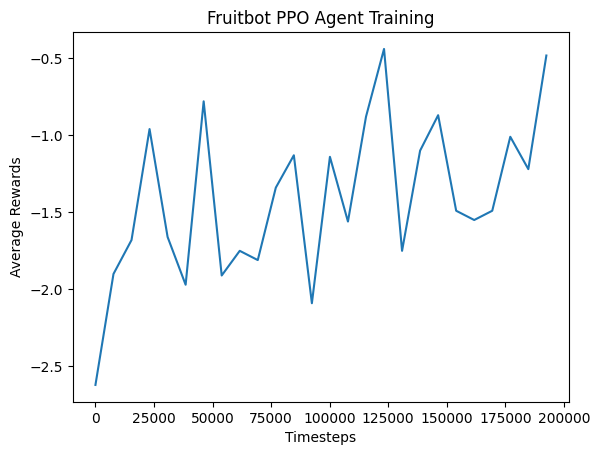

In [ ]:
#Plotting training score moving average to see training trends
mean_scores = mean_score(scores, 100)
plt.plot(range(0,time_steps-100,int(time_steps/len(mean_scores))),mean_scores)
plt.title('Fruitbot PPO Agent Training')
plt.xlabel('Timesteps')
plt.ylabel('Average Rewards')
plt.show()

## Testing PPO Agent

In [ ]:
env = gym.make("procgen:procgen-fruitbot-v0", distribution_mode="easy", use_backgrounds=False, start_level=seed, rand_seed=seed)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
test_episodes = 100

In [ ]:
#Testing random agent
random_agent_rewards = []

for episode in range(test_episodes):
    env.reset()
    total_reward = 0

    while True:
        state, reward, done, _ = env.step(env.action_space.sample())
        total_reward += reward

        if done:
            break

    random_agent_rewards.append(total_reward)

env.close()

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the envir

In [ ]:
#Testing PPO agent
fruitbot_ppoagent_rewards = []

for episode in range(test_episodes):
    env.reset()
    total_reward = 0

    while True:
        action = agent_fruitbot.action([state])
        state, reward, done, _ = env.step(action)
        total_reward += reward

        if done:
            break

    fruitbot_ppoagent_rewards.append(total_reward)

env.close()

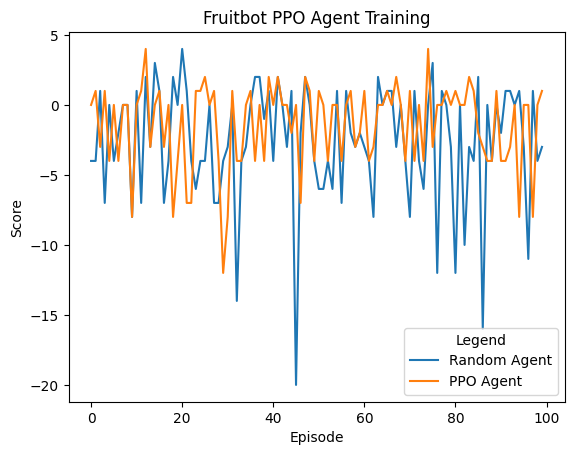

In [ ]:
#Plotting a comaprison between random agent and PPO agent
plt.plot(random_agent_rewards, label='Random Agent')
plt.plot(fruitbot_ppoagent_rewards, label='PPO Agent')
plt.title('Fruitbot PPO Agent Training')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.legend(title='Legend', loc='lower right', fontsize='medium')
plt.show()

In [ ]:
print(f"Fruitbot Random agent mean score over {test_episodes} episodes: {np.mean(random_agent_rewards)}")
print(f"Fruitbot PPO agent mean score over {test_episodes} episodes: {np.mean(fruitbot_ppoagent_rewards)}")

Fruitbot Random agent mean score over 100 episodes: -2.65
Fruitbot PPO agent mean score over 100 episodes: -1.39
